# QSVT Linear Solver (4×4 System, Exact Inverse via P(x) = x)

This notebook is the 4×4 analogue of the 2×2 example.

We exploit a **special class of matrices** where:

- $A$ is Hermitian,
- eigenvalues are all $\pm1$,
- therefore $A^2 = I  \Rightarrow  A^{-1} = A$.

For such matrices the QSVT polynomial:

$$P(x) = x$$

exactly equals $1/x$ on the spectrum $\pm1$.

Thus QSVT with `poly = [0, 1]` produces a block-encoding whose top-left 4×4 block equals $A$ precisely.

In [9]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt


We choose:

$$A = \text{diag}(1, -1, 1, -1)$$

which is Hermitian, involutory, and has eigenvalues ±1.

We choose $b = (1, 2, 3, 4)^T$.

Classical solution: $x = A^{-1} b = A b = (1, -2, 3, -4)^T$.

In [10]:
A = np.diag([1.0, -1.0, 1.0, -1.0])
b = np.array([1.0, 2.0, 3.0, 4.0])

evals, evecs = np.linalg.eigh(A)

x_classical = np.linalg.solve(A, b)
x_classical_norm = x_classical / np.linalg.norm(x_classical)

print("A =\n", A)
print("Eigenvalues:", evals)
print("b =", b)
print("Classical x =", x_classical)
print("Classical (normalized) =", x_classical_norm)


A =
 [[ 1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]]
Eigenvalues: [-1. -1.  1.  1.]
b = [1. 2. 3. 4.]
Classical x = [ 1. -2.  3. -4.]
Classical (normalized) = [ 0.18257419 -0.36514837  0.54772256 -0.73029674]


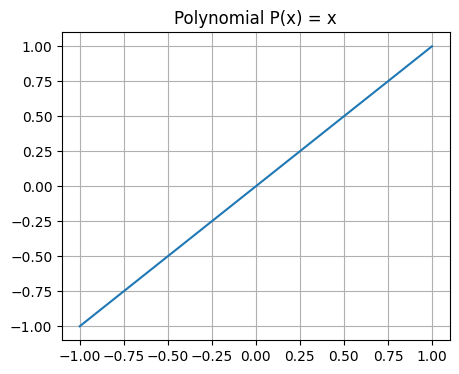

In [15]:
poly = np.array([0.0, 1.0])

x = np.linspace(-1,1,200)
plt.figure(figsize=(5,4))
plt.plot(x, poly[0] + poly[1]*x)
plt.title("Polynomial P(x) = x")
plt.grid()
plt.show()


## Block Encoding A with QSVT

For a 4×4 matrix, QSVT requires embedding into a unitary of dimension ≥ 8×8.
Thus we need **3 qubits**.

We call:

`qml.qsvt(A, poly, encoding_wires=[0,1,2])`

Then extract the top-left 4×4 block.


In [18]:
wire_order = [0,1,2]  # 3 qubits → 8×8 unitary

U_big = qml.matrix(qml.qsvt, wire_order=wire_order)(
    A, poly, encoding_wires=wire_order, block_encoding="embedding"
)

print("Full QSVT unitary:\n", np.round(U_big, 6))

# Extract top-left 4×4 block (logical action)
U_A = U_big[:4, :4]

print("\nTop-left 4×4 block:\n", np.round(U_A, 6))


Full QSVT unitary:
 [[ 1.+1.e-06j  0.+0.e+00j  0.+0.e+00j  0.+0.e+00j  0.+0.e+00j  0.+0.e+00j
   0.+0.e+00j  0.+0.e+00j]
 [ 0.+0.e+00j -1.-1.e-06j  0.+0.e+00j  0.+0.e+00j  0.+0.e+00j  0.+0.e+00j
   0.+0.e+00j  0.+0.e+00j]
 [ 0.+0.e+00j  0.+0.e+00j  1.+1.e-06j  0.+0.e+00j  0.+0.e+00j  0.+0.e+00j
   0.+0.e+00j  0.+0.e+00j]
 [ 0.+0.e+00j  0.+0.e+00j  0.+0.e+00j -1.-1.e-06j  0.+0.e+00j  0.+0.e+00j
   0.+0.e+00j  0.+0.e+00j]
 [ 0.+0.e+00j  0.+0.e+00j  0.+0.e+00j  0.+0.e+00j -1.+1.e-06j  0.+0.e+00j
   0.+0.e+00j  0.+0.e+00j]
 [ 0.+0.e+00j  0.+0.e+00j  0.+0.e+00j  0.+0.e+00j  0.+0.e+00j  1.-1.e-06j
   0.+0.e+00j  0.+0.e+00j]
 [ 0.+0.e+00j  0.+0.e+00j  0.+0.e+00j  0.+0.e+00j  0.+0.e+00j  0.+0.e+00j
  -1.+1.e-06j  0.+0.e+00j]
 [ 0.+0.e+00j  0.+0.e+00j  0.+0.e+00j  0.+0.e+00j  0.+0.e+00j  0.+0.e+00j
   0.+0.e+00j  1.-1.e-06j]]

Top-left 4×4 block:
 [[ 1.+1.e-06j  0.+0.e+00j  0.+0.e+00j  0.+0.e+00j]
 [ 0.+0.e+00j -1.-1.e-06j  0.+0.e+00j  0.+0.e+00j]
 [ 0.+0.e+00j  0.+0.e+00j  1.+1.e-06j  0.+0.e+0

## Solving via QSVT

QSVT acts on an 8-dimensional space.
The logical state $|b⟩$ occupies the first 4 components.

Steps:
1. Embed b into 8D.
2. Apply the 8×8 QSVT unitary.
3. Extract the first 4 components.
4. Normalize $\Rightarrow$ gives solution direction.


In [13]:
# Embed |b>
b_embed = np.zeros((8,), dtype=complex)
b_embed[:4] = b

# Apply QSVT unitary
x_embed = U_big @ b_embed

# Extract logical result
x_qsvt = x_embed[:4]
x_qsvt_norm = x_qsvt / np.linalg.norm(x_qsvt)

print("QSVT solution (normalized) =", x_qsvt_norm)
print("Classical solution (normalized) =", x_classical_norm)

QSVT solution (normalized) = [ 0.18257419+2.58196034e-07j -0.36514837-5.16392068e-07j
  0.54772256+7.74588102e-07j -0.73029674-1.03278414e-06j]
Classical solution (normalized) = [ 0.18257419 -0.36514837  0.54772256 -0.73029674]


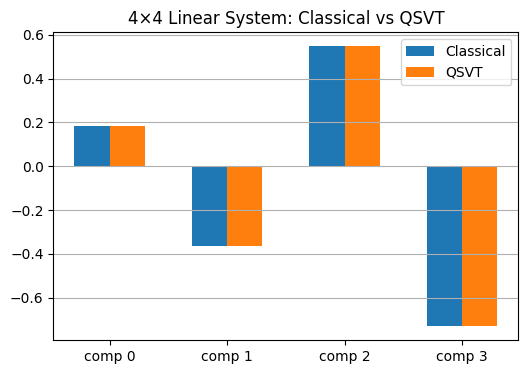

In [ ]:
# Plot comparison
indices = np.arange(4)
plt.figure(figsize=(6,4))
plt.bar(indices-0.15, np.real(x_classical_norm), width=0.3, label="Classical")
plt.bar(indices+0.15, np.real(x_qsvt_norm), width=0.3, label="QSVT")
plt.title("4×4 Linear System: Classical vs QSVT")
plt.grid(True, axis="y")
plt.xticks(indices, [f"comp {i}" for i in range(4)])
plt.legend()
plt.show()


## Summary

- We constructed a 4×4 Hermitian involutory matrix $A$ with eigenvalues $\pm1$.
- For such $A = A^{-1}$.
- QSVT with $P(x) = x$ yields a block-encoding whose top-left 4×4 block equals $A$ exactly.
- After embedding $b$ into the enlarged Hilbert space and applying the full QSVT unitary, the extracted state matches the classical solution.
